In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 10 variables share a factor structure and the other 20 are noise

In [2]:
N = 50000
D_factor = 10
D_noise = 20
D = D_factor + D_noise
P = 3

V = np.abs(np.random.normal(1.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0, 1, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor+D_noise))
X = np.random.poisson(1.,size=(N,D_noise+D_factor))
X[:, ::3] = np.random.poisson(ZV)

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    scale_rates=True, with_s=True,
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


In [5]:
losses = factor.calibrate_advi(
    num_epochs=200, learning_rate=.1)




W0604 09:33:58.254903 4603870656 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 57.73558764066866
Epoch 1: average-batch loss: 53.81824359627665 last batch loss: 53.28997756997598
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 52.54408918387699 last batch loss: 52.234162657365125
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 51.61245086404765 last batch loss: 51.375159926501574
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 50.87532751947661 last batch loss: 50.73142827765426
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 50.5296842536969 last batch loss: 50.535977429079466
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 49.96354488647245 last batch loss: 49.470640554144744
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 48.451906260999785 last batch loss: 47.945292393791874
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 47.42285915811596 last batch loss: 47.34844602833972
Saved a checkpoint: ./.tf_c

Epoch 73: average-batch loss: 46.35957028904929 last batch loss: 46.57135956156215
We are in a loss plateau learning rate: 0.04304672100000001 loss: 46.29552758939385
Restoring from a checkpoint - loss: 46.30770135990951
Epoch 74: average-batch loss: 46.363583827227956 last batch loss: 46.55401349165243
Epoch 75: average-batch loss: 46.36327364664955 last batch loss: 46.57342172808507
Epoch 76: average-batch loss: 46.36097597882199 last batch loss: 46.52794274384473
Epoch 77: average-batch loss: 46.356116073898264 last batch loss: 46.530637871733504
Epoch 78: average-batch loss: 46.35423078017348 last batch loss: 46.52488436408797
Saved a checkpoint: ./.tf_ckpts/chkpt-33
Epoch 79: average-batch loss: 46.35563160668855 last batch loss: 46.55226966656095
Epoch 80: average-batch loss: 46.36274343948366 last batch loss: 46.55957242453919
We are in a loss plateau learning rate: 0.03874204890000001 loss: 46.29376164241894
Restoring from a checkpoint - loss: 46.34193325797089
Epoch 81: averag

Epoch 149: average-batch loss: 46.355756272956256 last batch loss: 46.57846598421325
Epoch 150: average-batch loss: 46.357214382486674 last batch loss: 46.57068014825694
Epoch 151: average-batch loss: 46.36336414239959 last batch loss: 46.556026874713694
Epoch 152: average-batch loss: 46.35639327791725 last batch loss: 46.55625516796462
Epoch 153: average-batch loss: 46.3553579778713 last batch loss: 46.56843361567017
Epoch 154: average-batch loss: 46.35499439801592 last batch loss: 46.5505188481933
Epoch 155: average-batch loss: 46.354196730172006 last batch loss: 46.555816952724946
Epoch 156: average-batch loss: 46.35653790544252 last batch loss: 46.54530538537332
We are in a loss plateau learning rate: 0.012157665459056936 loss: 46.32134604543714
Restoring from a checkpoint - loss: 46.28239797653753
Epoch 157: average-batch loss: 46.35085781466837 last batch loss: 46.517452906950716
Epoch 158: average-batch loss: 46.3565256000545 last batch loss: 46.558903658722656
Epoch 159: averag

In [6]:
waic = factor.waic()
print(waic)

{'waic': 434829.5862352768, 'se': 2675.7859682701414, 'lppd': -39666.8036746372, 'pwaic': 177747.9894430012}


In [7]:

surrogate_samples = factor.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data = az.convert_to_inference_data(
        {
            r"$w_d$": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.column_norm_factor).numpy().T})
else:
    intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*factor.column_norm_factor).numpy().T})

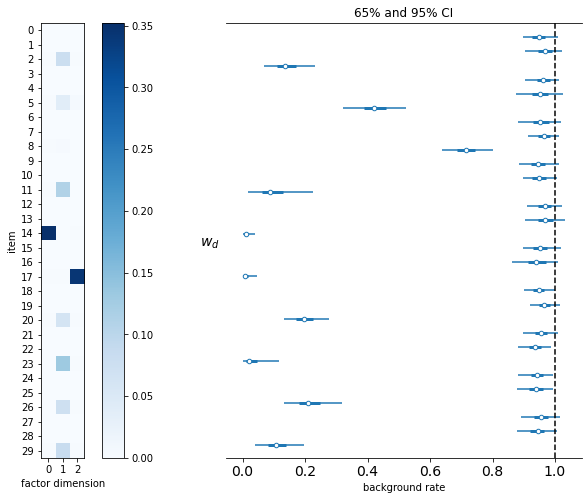

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
#plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


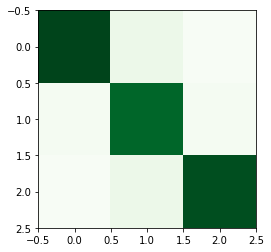

In [9]:
plt.imshow(factor.decoding_matrix().numpy().dot(factor.encoding_matrix().numpy()),cmap="Greens")